In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'healthcare-mri-for-brain-tumor:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1031109%2F1737153%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240429%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240429T040520Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D624764ebe7b9ffe51787bc7536337d5f25de9e8c0955748fa456383ce5b122bbdefa4a849b25ce6cd227b4035ef8c25f5db899c69650aa80a47d32490e2a17aaa52e758b6523121eadb2d250db00fcb247d7c45aff3dd6c27da92ad43f96fbedfcc9e1a7b3fffceabe053eb372fe2fea21b0ebab623264d91f03518f87daef91b4d4def77461070542047b3e349149b632a591b51238f7f30ad087b282177bf0125dd0acd59c650db925606810cc1ca870b7b1eb75b730f44d82565e98cd23e8739133e562c896f95bf51687013b8487785c9e4e6655245fe3ffddd6f301002fc617bcb0334939ea4a4fcd2e83a605c24e4e3e2f83216818ebb943b59cfef2f2'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


#  IMPORT LIBRARIES AND DATASETS

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
%matplotlib inline

In [ ]:
# Navigate to My Drive directory to store the dataset
%cd /kaggle/input/healthcare-mri-for-brain-tumor/Healthcare AI Datasets/Brain_MRI


/kaggle/input/healthcare-mri-for-brain-tumor/Healthcare AI Datasets/Brain_MRI


In [ ]:
# data containing path to Brain MRI and their corresponding mask
brain_df = pd.read_csv('data_mask.csv')

In [ ]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [ ]:
brain_df.head()

patient_id                                         image_path  \
0  TCGA_CS_5395_19981004  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1  TCGA_CS_5395_19981004  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2  TCGA_CS_5395_19981004  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3  TCGA_CS_5395_19981004  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4  TCGA_CS_5395_19981004  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   

                                           mask_path  mask  
0  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0

In [ ]:
brain_df.mask_path[1] # Path to the brain MRI image

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif'

In [ ]:
brain_df.image_path[1] # Path to the segmentation mask

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif'

# PERFORM DATA VISUALIZATION

In [ ]:
brain_df[:5]

patient_id                                         image_path  \
0  TCGA_CS_5395_19981004  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1  TCGA_CS_5395_19981004  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2  TCGA_CS_5395_19981004  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3  TCGA_CS_5395_19981004  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4  TCGA_CS_5395_19981004  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   

                                           mask_path  mask  
0  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0

In [ ]:
brain_df['mask'].value_counts().index

Int64Index([0, 1], dtype='int64')

In [ ]:
# Use plotly to plot interactive bar chart
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])
fig.update_traces(marker_color = 'rgb(0,200,0)', marker_line_color = 'rgb(0,0,0)',
                  marker_line_width = 2, opacity = 0.6)
fig.show()

In [ ]:
# Obtain the percentage of images with mask
round((brain_df['mask'].value_counts()* 100 / len(brain_df['mask'])),2)

0    65.05
1    34.95
Name: mask, dtype: float64

In [ ]:
brain_df.mask_path[:5]

0    TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...
1    TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...
2    TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...
3    TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...
4    TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...
Name: mask_path, dtype: object

In [ ]:
brain_df.image_path[:5]

0    TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif
1    TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif
2    TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
3    TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif
4    TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif
Name: image_path, dtype: object

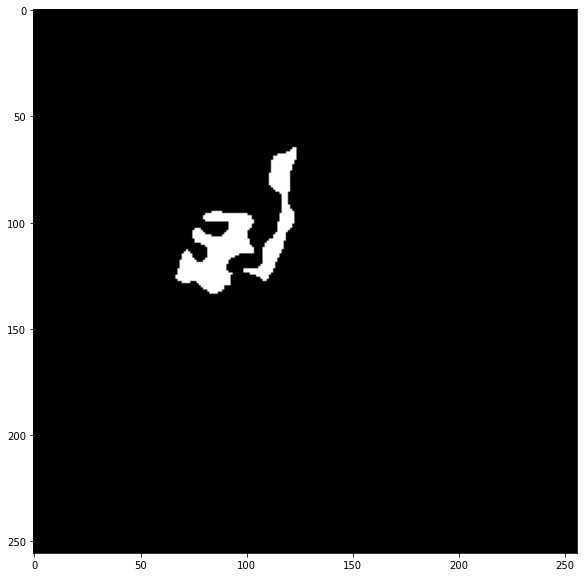

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(cv2.imread(brain_df.mask_path[2490]))
plt.show()

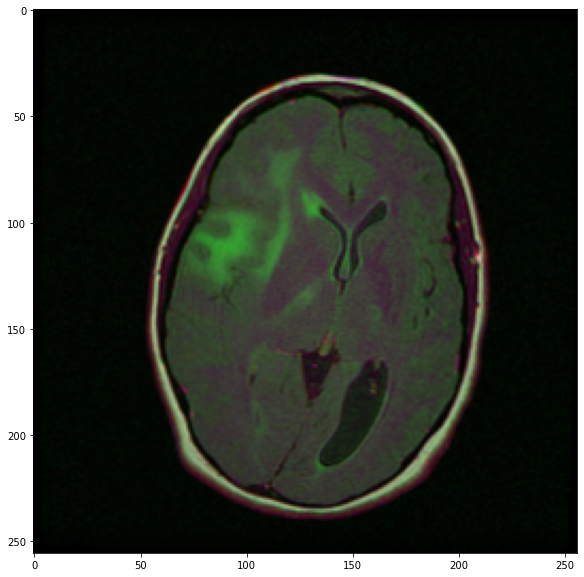

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(cv2.imread(brain_df.image_path[2490]))
plt.show()

In [ ]:
cv2.imread(brain_df.mask_path[2490]).max()

255

In [ ]:
cv2.imread(brain_df.mask_path[2490]).min()

0

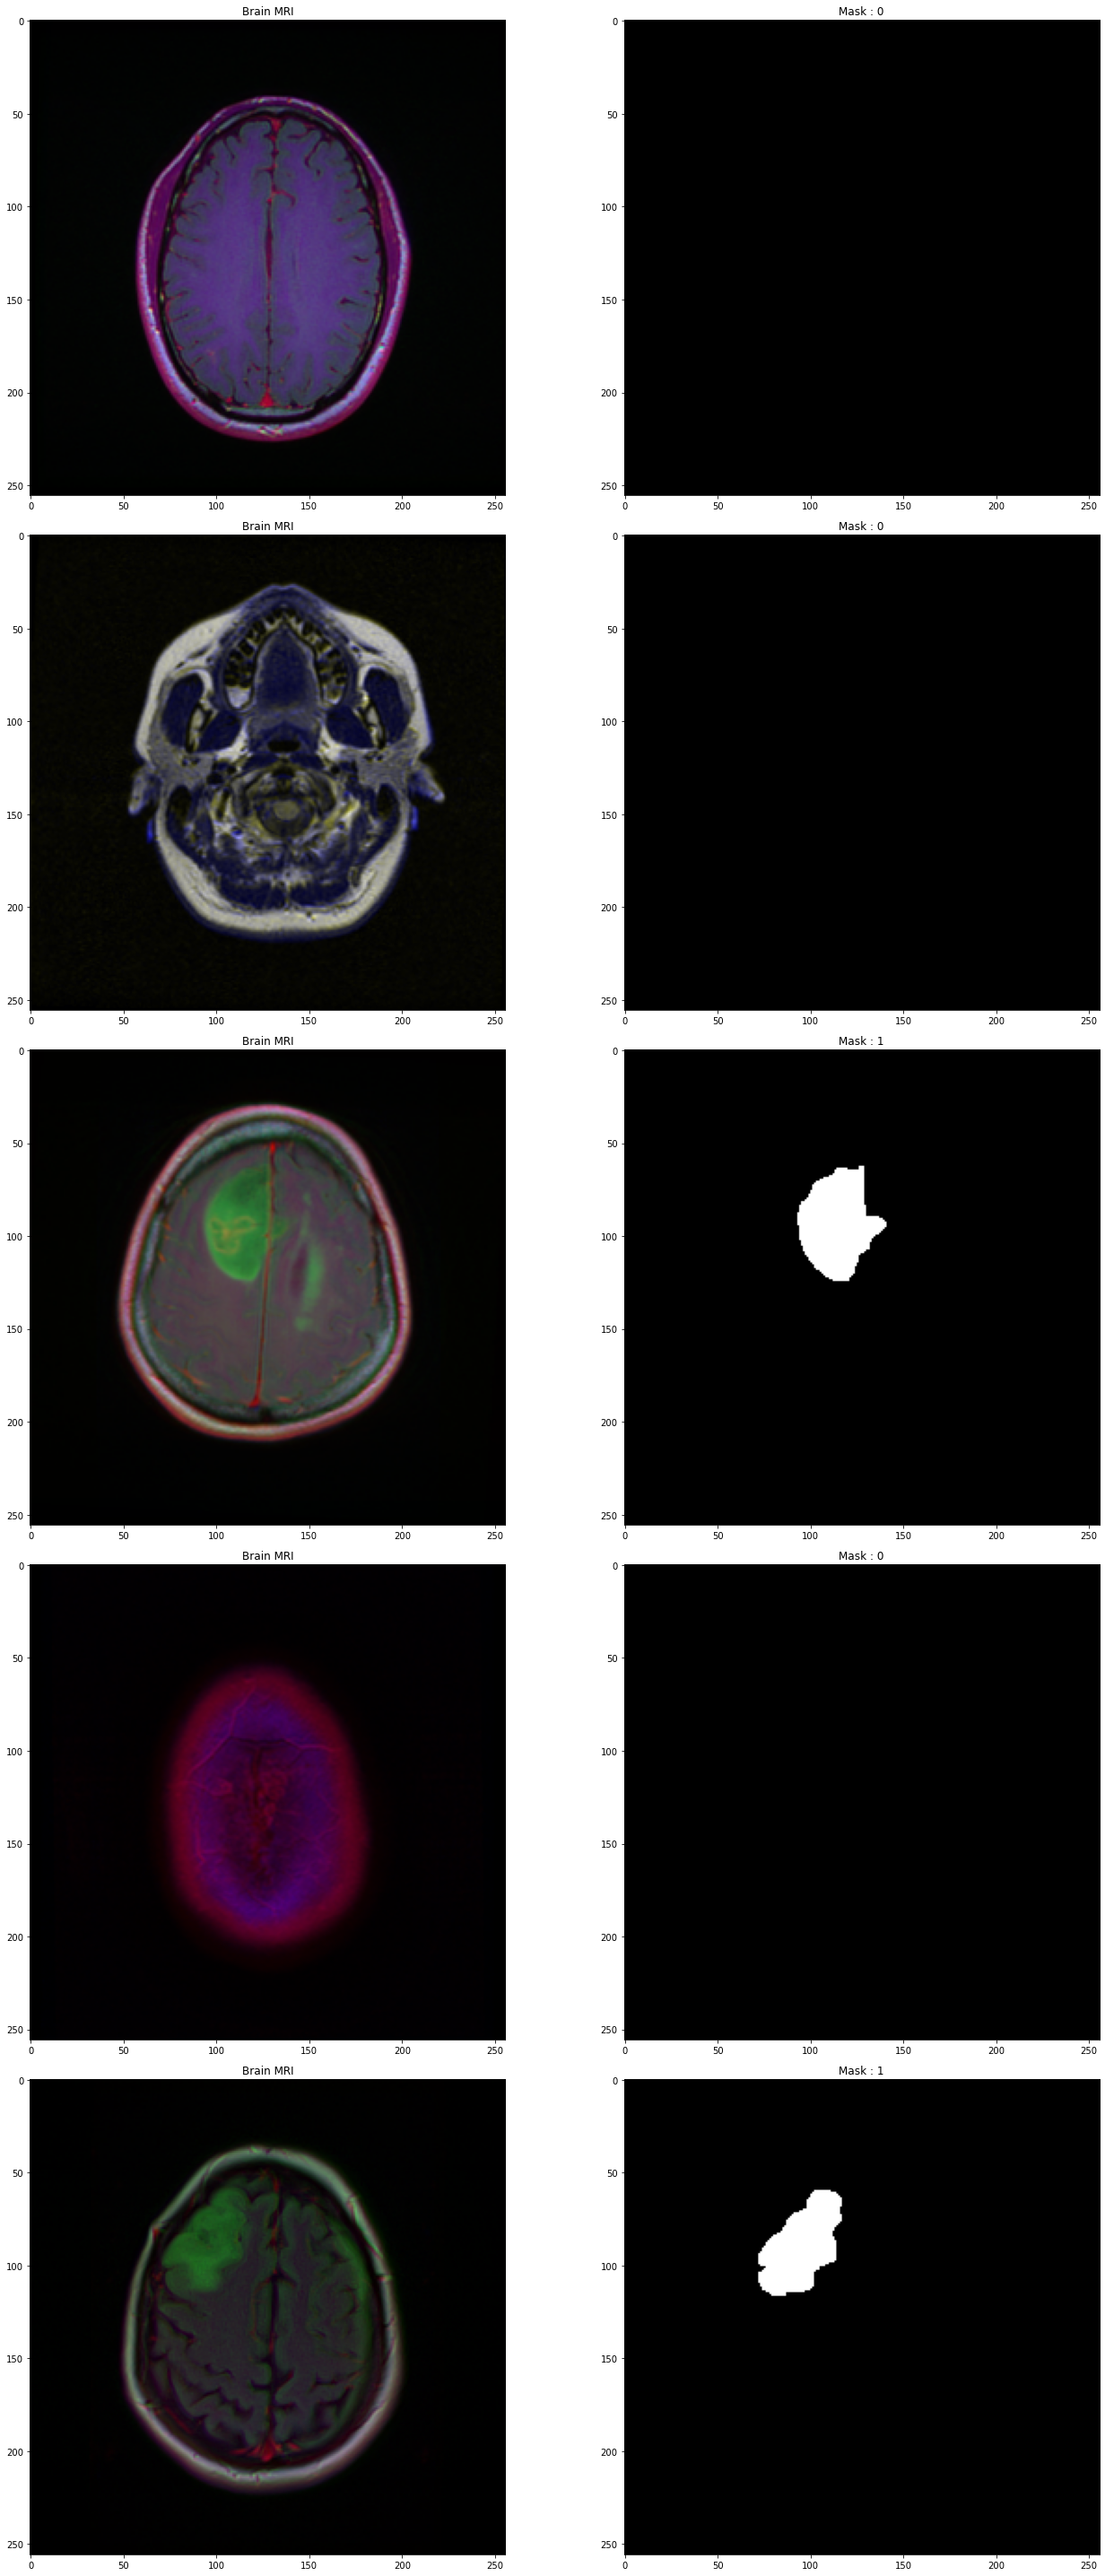

In [ ]:
# Basic visualizations: Visualize the images (MRI and Mask) in the dataset separately
import random
fig, axs = plt.subplots(5,2, figsize=(20,40))
count = 0
for x in range(5):
  i = random.randint(0, len(brain_df)) # select a random index
  axs[count][0].title.set_text("Brain MRI") # set title
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # show MRI
  axs[count][1].title.set_text("Mask : " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Show corresponding mask
  count += 1

fig.tight_layout()

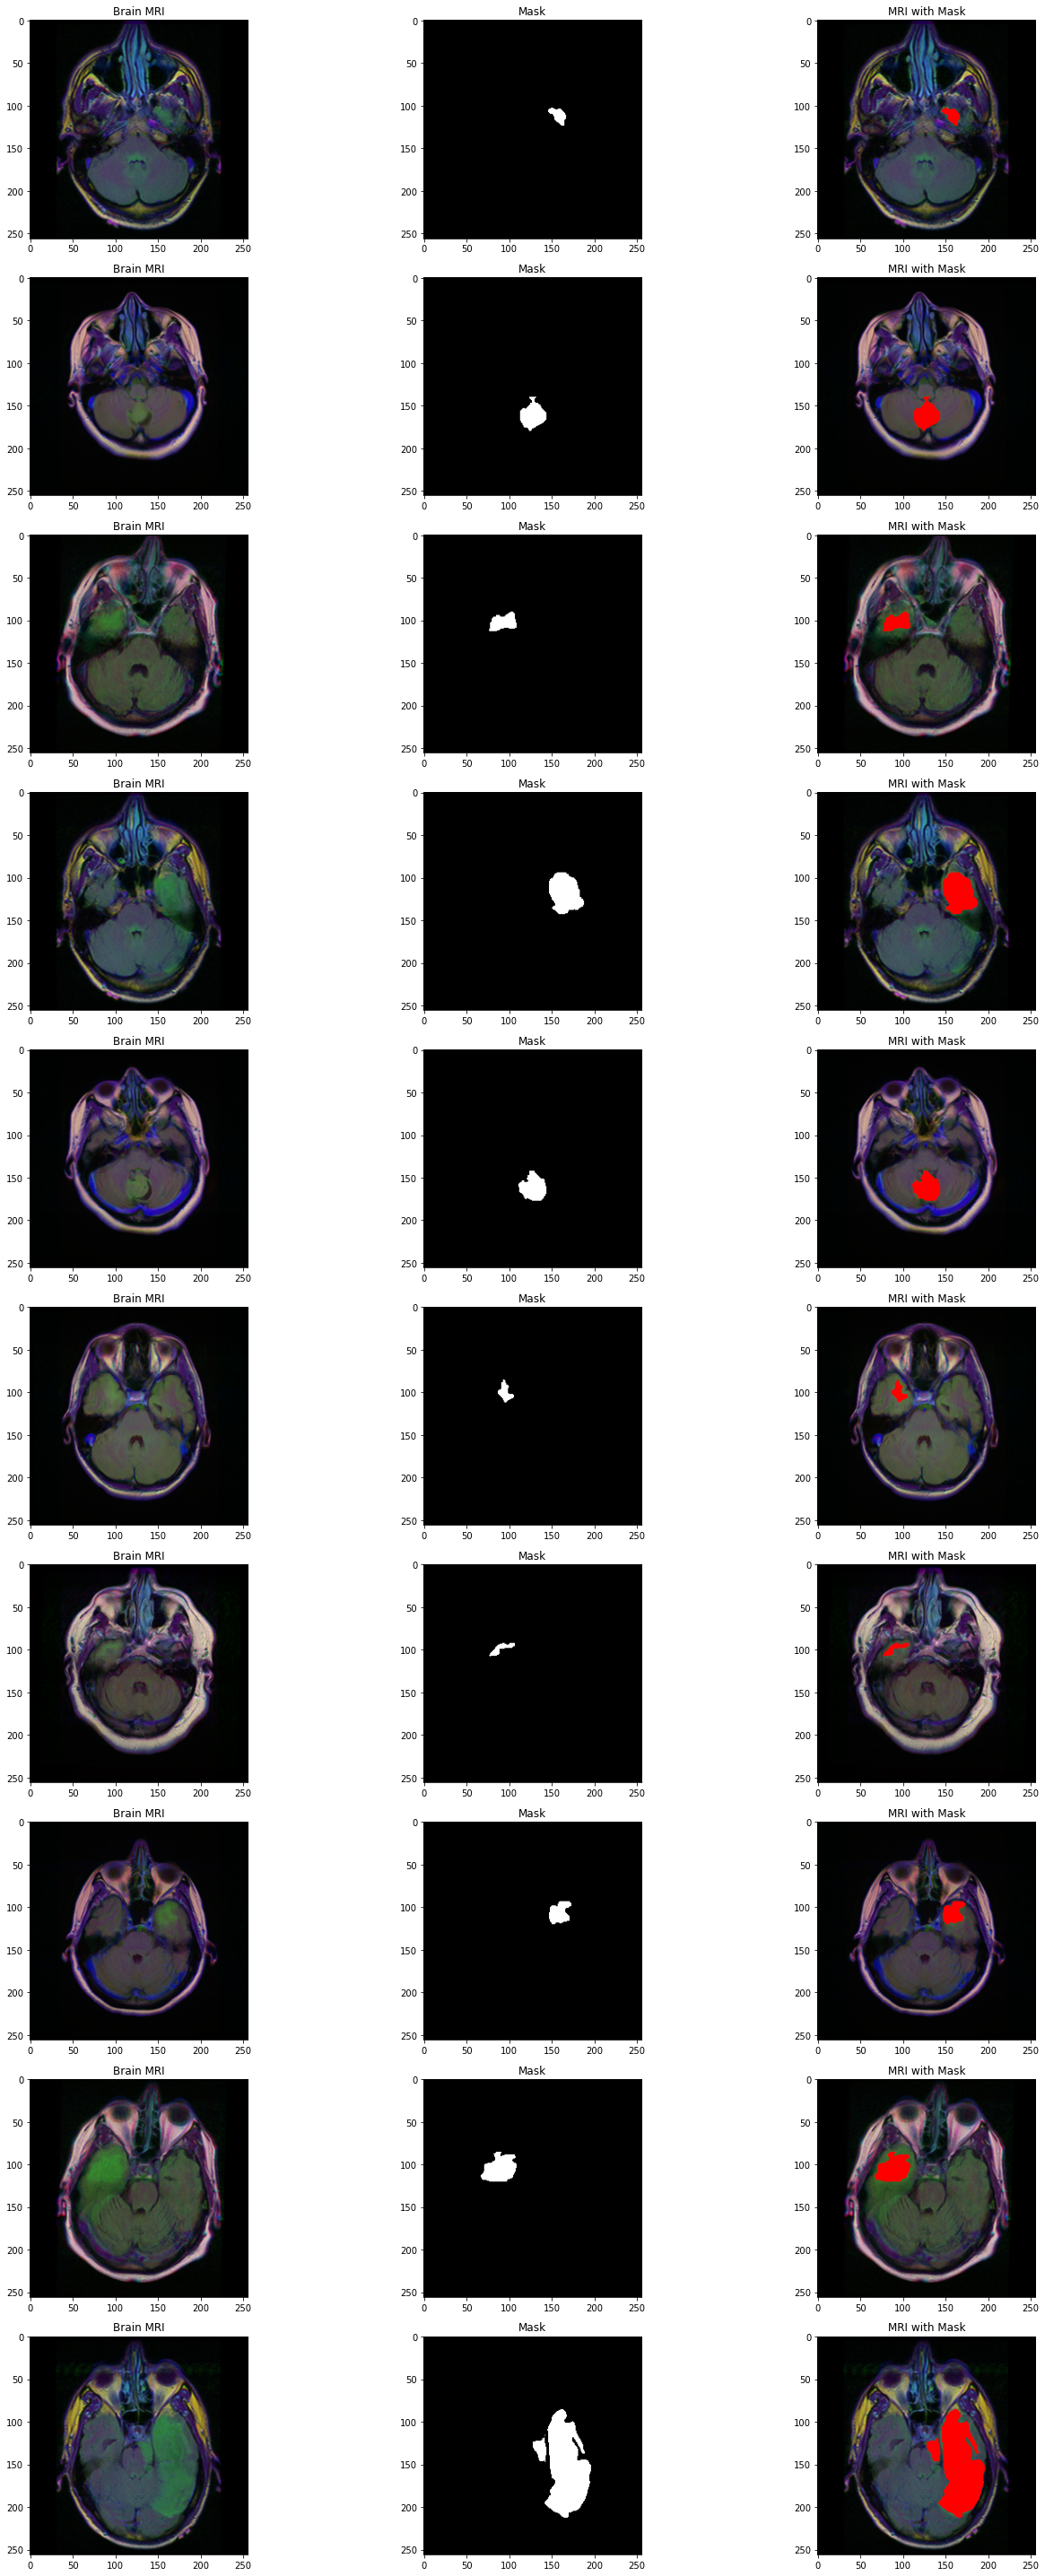

In [ ]:
# Advanced Visualization: visualize the MRI scans along with their mask on one image
count = 0
fig, axs = plt.subplots(10, 3, figsize = (20, 40))
for i in range(len(brain_df)):
  if brain_df['mask'][i] ==1 and count <10:
    img = io.imread(brain_df.image_path[i])
    axs[count][0].title.set_text('Brain MRI')
    axs[count][0].imshow(img)

    mask = io.imread(brain_df.mask_path[i])
    axs[count][1].title.set_text('Mask')
    axs[count][1].imshow(mask, cmap = 'gray')


    img[mask == 255] = (255, 0, 0)
    axs[count][2].title.set_text('MRI with Mask')
    axs[count][2].imshow(img)
    count+=1

fig.tight_layout()


# TRAIN A CLASSIFIER MODEL TO DETECT IF TUMOR EXISTS OR NOT

In [ ]:
# Drop the patient id column
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [ ]:
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [ ]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [ ]:
# split the data into train and test data

from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size = 0.2,random_state=42)

In [ ]:
# create a image generator
from keras_preprocessing.image import ImageDataGenerator

# Create a data generator which scales the data from 0 to 1 and makes validation split of 0.1
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.1)


In [ ]:
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Create a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))



Found 2829 validated image filenames belonging to 2 classes.
Found 314 validated image filenames belonging to 2 classes.
Found 786 validated image filenames belonging to 2 classes.


In [ ]:
# Get the ResNet50 base model
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

In [ ]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
# freeze the model weights

for layer in basemodel.layers:
  layers.trainable = False

In [ ]:
# Add classification head to the base model

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.25)(headmodel)#
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.25)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.25)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=25
                             )
checkpointer = ModelCheckpoint(filepath="/kaggle/working/classifier-resnet-weights.hdf5",
                               verbose=1,
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )
callbacks = [checkpointer, earlystopping, reduce_lr]

In [ ]:
# compile the model

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
history = model.fit(train_generator,
              steps_per_epoch= train_generator.n // train_generator.batch_size,
              epochs = 20,
              validation_data= valid_generator,
              validation_steps= valid_generator.n // valid_generator.batch_size,
              callbacks = [checkpointer, earlystopping, reduce_lr])

Epoch 1/20
176/176 [==============================] - ETA: 0s - loss: 0.7094 - accuracy: 0.7199
Epoch 00001: val_loss improved from inf to 15.55326, saving model to /kaggle/working/classifier-resnet-weights.hdf5
176/176 [==============================] - 25s 143ms/step - loss: 0.7094 - accuracy: 0.7199 - val_loss: 15.5533 - val_accuracy: 0.3487
Epoch 2/20
176/176 [==============================] - ETA: 0s - loss: 0.4624 - accuracy: 0.7807
Epoch 00002: val_loss improved from 15.55326 to 0.90288, saving model to /kaggle/working/classifier-resnet-weights.hdf5
176/176 [==============================] - 24s 136ms/step - loss: 0.4624 - accuracy: 0.7807 - val_loss: 0.9029 - val_accuracy: 0.6480
Epoch 3/20
176/176 [==============================] - ETA: 0s - loss: 0.3988 - accuracy: 0.8365
Epoch 00003: val_loss did not improve from 0.90288
176/176 [==============================] - 23s 129ms/step - loss: 0.3988 - accuracy: 0.8365 - val_loss: 1.4485 - val_accuracy: 0.6480
Epoch 4/20
176/176 [==

U-NET

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose

def unet(input_shape=(256, 256, 3)):
    inputs = Input(input_shape)

    # Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Expansive Path
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same', kernel_initializer='he_normal')(drop5)
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same', kernel_initializer='he_normal')(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same', kernel_initializer='he_normal')(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same', kernel_initializer='he_normal')(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Example usage:
model = unet(input_shape=(256, 256, 3))
model.summary()


# Save the model architecture to json file for future use


In [ ]:
model_json = model.to_json()
with open("/kaggle/working/classifierresnetmodel.json", "w") as json_file:
    json_file.write(model_json)

# ASSESS TRAINED MODEL PERFORMANCE

In [ ]:
with open('/kaggle/working/classifierresnetmodel.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('/kaggle/working/classifier-resnet-weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
# make prediction

test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

49/49 [==============================] - 8s 161ms/step


In [ ]:
test_predict.shape

(784, 2)

In [ ]:
test_predict[:5]

array([[1.2563865e-10, 1.0000000e+00],
       [8.4224343e-01, 1.5775660e-01],
       [9.5711780e-01, 4.2882279e-02],
       [9.0190165e-02, 9.0980989e-01],
       [9.9999404e-01, 5.9890444e-06]], dtype=float32)

In [ ]:
# Obtain the predicted class from the model prediction
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [ ]:
predict

array(['1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '1', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1',
       '0', '0', '0', '1', '1', '0', '1', '0', '0', '1', '1', '0', '1',
       '0', '1', '1', '0', '0', '1', '1', '0', '0', '0', '0', '1', '0',
       '1', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0',
       '1', '1', '0', '0', '1', '1', '1', '1', '0', '0', '1', '0', '1',
       '0', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '0', '0',
       '0', '1', '1', '1', '1', '0', '1', '1', '1', '0', '1', '1', '0',
       '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0',
       '1', '1', '0', '1', '1', '0', '0', '1', '1', '1', '0', '1', '1',
       '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0',
       '1', '0', '0', '1', '0', '1', '0', '1', '0', '1', '1', '1', '0',
       '1', '0', '0', '0', '1', '1', '1', '0', '1', '0', '1', '1', '0',
       '0', '0', '1', '0', '0', '1', '0', '1', '0', '0', '0', '0

In [ ]:
# since we have used test generator, it limited the images to len(predict), due to batch size
original = np.asarray(test['mask'])[:len(predict)]
len(original)

784

In [ ]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = round(accuracy_score(original, predict),2)
accuracy

0.95

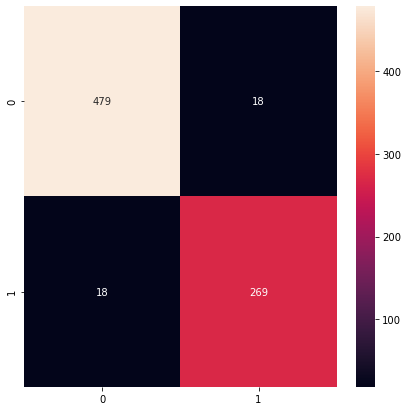

In [ ]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True,fmt='d')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       497
           1       0.94      0.94      0.94       287

   micro avg       0.95      0.95      0.95       784
   macro avg       0.95      0.95      0.95       784
weighted avg       0.95      0.95      0.95       784



/opt/conda/lib/python3.7/site-packages/numpy/lib/arraysetops.py:564: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



# BUILD A SEGMENTATION MODEL TO LOCALIZE TUMOR USING U-NET


In [ ]:
# Get the dataframe containing MRIs which have masks associated with them.
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [ ]:
# split the data into train and test data

from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(brain_df_mask, test_size=0.2,random_state=42)
X_test, X_val = train_test_split(X_val, test_size=0.5,random_state=42)

In [ ]:
X_train.shape,X_test.shape, X_val.shape

((1098, 4), (137, 4), (138, 4))

In [ ]:
# create separate list for imageId, classId to pass into the generator

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

In [ ]:
# Utilities file contains the code for custom loss function and custom data generator
from utilities import DataGenerator

# create image generators

training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose

def unet(input_shape=(256, 256, 3)):
    # Input tensor shape
    inputs = Input(input_shape)

    # Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Expansive Path
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same', kernel_initializer='he_normal')(drop5)
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same', kernel_initializer='he_normal')(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same', kernel_initializer='he_normal')(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same', kernel_initializer='he_normal')(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    return model


model_seg = unet(input_shape=(256, 256, 3))
model_seg.summary()


Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Compile the model
model_seg.compile(optimizer=Adam(lr=1e-4), loss=binary_crossentropy, metrics=[MeanIoU(num_classes=2)])

# Define callbacks
checkpoint = ModelCheckpoint("unet_brain_tumor.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

# Train the model
history = model_seg.fit(training_generator, epochs=20, validation_data=validation_generator, callbacks=[checkpoint, early_stopping])



# Example of using the trained model to predict on a single image
# single_image_prediction = model_seg.predict(single_image)


Epoch 1/20
68/68 [==============================] - ETA: 0s - loss: 0.6911 - mean_io_u_1: 0.4853
Epoch 00001: val_loss improved from inf to 0.68950, saving model to unet_brain_tumor.h5
68/68 [==============================] - 26s 385ms/step - loss: 0.6911 - mean_io_u_1: 0.4853 - val_loss: 0.6895 - val_mean_io_u_1: 0.4851
Epoch 2/20
68/68 [==============================] - ETA: 0s - loss: 0.6879 - mean_io_u_1: 0.4853
Epoch 00002: val_loss improved from 0.68950 to 0.68632, saving model to unet_brain_tumor.h5
68/68 [==============================] - 25s 364ms/step - loss: 0.6879 - mean_io_u_1: 0.4853 - val_loss: 0.6863 - val_mean_io_u_1: 0.4854
Epoch 3/20
68/68 [==============================] - ETA: 0s - loss: 0.6848 - mean_io_u_1: 0.4853
Epoch 00003: val_loss improved from 0.68632 to 0.68319, saving model to unet_brain_tumor.h5
68/68 [==============================] - 25s 363ms/step - loss: 0.6848 - mean_io_u_1: 0.4853 - val_loss: 0.6832 - val_mean_io_u_1: 0.4847
Epoch 4/20
68/68 [=====

NameError: name 'test_images' is not defined

In [ ]:
# Make predictions
predicted_masks = model_seg.predict(test_generator)

In [ ]:
def resblock(X, f):


  # make a copy of input
  X_copy = X

  # main path
  # Read more about he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  # Read more here: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [ ]:
# function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [ ]:
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


In [ ]:
model_seg.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        batch_normalization[0][0]        
_______________________________________________________________________________________

# TRAIN A SEGMENTATION U-NET MODEL TO LOCALIZE TUMOR

In [ ]:
"""@article{focal-unet,
  title={A novel Focal Tversky loss function with improved Attention U-Net for lesion segmentation},
  author={Abraham, Nabila and Khan, Naimul Mefraz},
  journal={arXiv preprint arXiv:1810.07842},
  year={2018}
}"""

'@article{focal-unet,\n  title={A novel Focal Tversky loss function with improved Attention U-Net for lesion segmentation},\n  author={Abraham, Nabila and Khan, Naimul Mefraz},\n  journal={arXiv preprint arXiv:1810.07842},\n  year={2018}\n}'

In [ ]:
# Utilities file contains the code for custom loss function and custom data generator

from utilities import tversky_loss, tversky

In [ ]:
def focal_tversky(y_true,y_pred):
    ## IMPORTANT NOTE:
    ## It seems that the type of y_true and y_pred are not the same. One is of type
    ## float32 and other int64. They need to be cast as the same type for the training
    ## to actually work.
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    #print(type(y_pred))
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

In [ ]:
# compling model and callbacks functions
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam,
                  loss = focal_tversky,
                  metrics = [tversky]
                 )
#callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=25
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="/kaggle/workingResUNet-weights.hdf5",
                               verbose=1,
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

In [ ]:
history = model_seg.fit(training_generator, epochs = 30, validation_data = validation_generator,
                        callbacks = [checkpointer, earlystopping,reduce_lr])

Epoch 1/30
68/68 [==============================] - ETA: 0s - loss: 0.9356 - tversky: 0.0849
Epoch 00001: val_loss improved from inf to 0.93876, saving model to /kaggle/workingResUNet-weights.hdf5
68/68 [==============================] - 25s 374ms/step - loss: 0.9356 - tversky: 0.0849 - val_loss: 0.9388 - val_tversky: 0.0808
Epoch 2/30
68/68 [==============================] - ETA: 0s - loss: 0.9353 - tversky: 0.0853
Epoch 00002: val_loss improved from 0.93876 to 0.93430, saving model to /kaggle/workingResUNet-weights.hdf5
68/68 [==============================] - 26s 376ms/step - loss: 0.9353 - tversky: 0.0853 - val_loss: 0.9343 - val_tversky: 0.0866
Epoch 3/30
68/68 [==============================] - ETA: 0s - loss: 0.9352 - tversky: 0.0854
Epoch 00003: val_loss did not improve from 0.93430
68/68 [==============================] - 24s 359ms/step - loss: 0.9352 - tversky: 0.0854 - val_loss: 0.9357 - val_tversky: 0.0848
Epoch 4/30
68/68 [==============================] - ETA: 0s - loss: 

In [ ]:
# save the model architecture to json file for future use

model_json = model_seg.to_json()
with open("/kaggle/working/ResUNet-model.json","w") as json_file:
  json_file.write(model_json)

#  ASSESS TRAINED SEGMENTATION U-NET MODEL PERFORMANCE

In [ ]:
from utilities import focal_tversky, tversky_loss, tversky

with open('/kaggle/input/healthcare-mri-for-brain-tumor/Healthcare AI Datasets/Brain_MRI/ResUNet-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model architecture
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('/kaggle/input/healthcare-mri-for-brain-tumor/Healthcare AI Datasets/Brain_MRI/weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [ ]:
# Utilities file contains the code for custom loss function and custom data generator
from utilities import prediction

# making prediction
image_id, mask, has_mask = prediction(test, model, model_seg)

In [ ]:
# creating a dataframe for the result
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred.head()

image_path  \
0  TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_17...   
1  TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_14...   
2  TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_19...   
3  TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_11...   
4  TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_54...   

                                      predicted_mask  has_mask  
0  [[[[5.8435285e-07], [2.0868015e-06], [4.203418...         1  
1                                            No mask         0  
2                                            No mask         0  
3                                            No mask         0  
4                                            No mask         0

In [ ]:
# Merge the dataframe containing predicted results with the original test data.
df_pred = test.merge(df_pred, on = 'image_path')
df_pred.head()

image_path  \
0  TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_17...   
1  TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_14...   
2  TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_19...   
3  TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_11...   
4  TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_54...   

                                           mask_path mask  \
0  TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_17...    1   
1  TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_14...    0   
2  TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_19...    0   
3  TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_11...    0   
4  TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_54...    0   

                                      predicted_mask  has_mask  
0  [[[[5.8435285e-07], [2.0868015e-06], [4.203418...         1  
1                                            No mask         0  
2                                            No mask         0  
3                                            No mask         0  
4                                            No mask         0

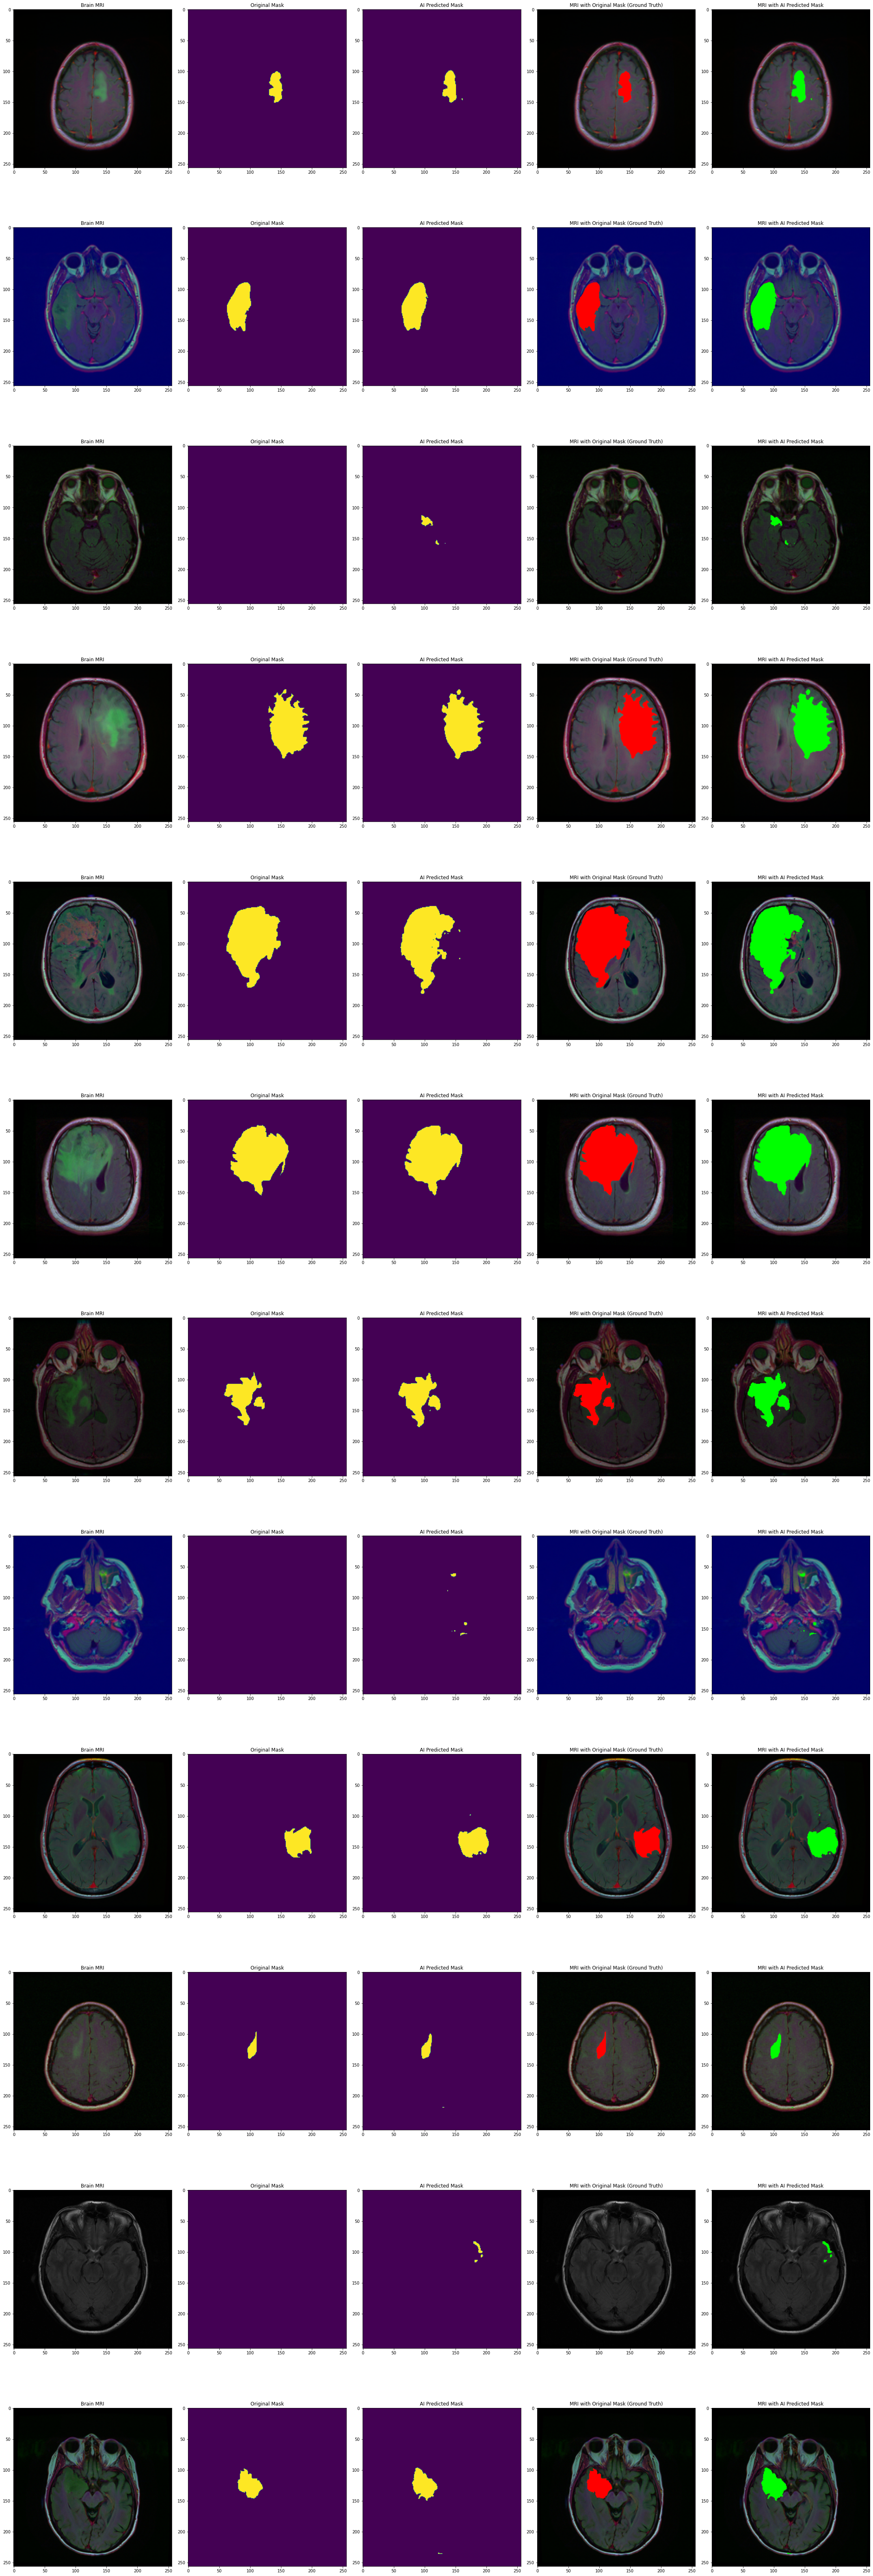

In [ ]:
count = 0
fig, axs = plt.subplots(12, 5, figsize=(30,90))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 12:
    # read the images and convert them to RGB format
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # Obtain the mask for the image
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    # Obtain the predicted mask for the image
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask)

    # Apply the mask to the image 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI with AI Predicted Mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()